# 간단하게 Fashion MNIST를 활용해서 모델을 학습 시키는 코드 with Pytorch

In [129]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from tqdm import tqdm

In [130]:
train_data = datasets.FashionMNIST(
    root = 'data',
    download=True,
    train = True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    download=True,
    train=False,
    transform=ToTensor()
)

The shape of X : torch.Size([64, 1, 28, 28])
The type of y ": torch.int64


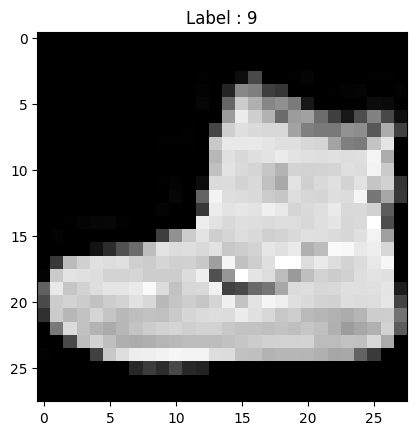

In [131]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f'The shape of X : {X.shape}')
    print(f'The type of y ": {y.dtype}')

    # 64개의 데이터중에서 가장 처음 데이터를 시각화 한다.
    image = X[0]
    label = y[0]

    if image.shape[0] == 1 :
        image = image.squeeze(0)
    else:
        image = image.permute(1, 2, 0)

    plt.imshow(image, cmap ='gray' if image.ndim == 2 else None)
    plt.title(f'Label : {label}')
    plt.show()

    break



In [132]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [133]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [134]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [135]:
def train(train_dataloader, model, loss_fn, optimizer):
    total_loss = 0
    for X, y in tqdm(train_dataloader, desc = 'Training'):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f'Average Training loss : {total_loss  / len(train_dataloader)}')

In [136]:
def test(test_dataloader, model, loss_fn):
    model.eval()
    total_loss, correct = 0, 0
    num_samples = 0  # 테스트 샘플의 총 수를 계산하기 위한 변수

    with torch.no_grad():
        for X, y in tqdm(test_dataloader, desc='Testing'):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            num_samples += y.size(0)  # 배치의 샘플 수를 더함

    average_loss = total_loss / len(test_dataloader)  # 평균 손실
    accuracy = correct / num_samples * 100  # 정확도 (퍼센트)

    print(f'Average test loss: {average_loss:.4f}')
    print(f'Accuracy: {accuracy:.2f}%')

In [128]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


Training: 100%|██████████| 938/938 [00:21<00:00, 44.64it/s]


Average Training loss : 0.7559644289171772


Testing: 100%|██████████| 157/157 [00:01<00:00, 139.10it/s]


Average test loss: 0.5187
Accuracy: 81.15%
Epoch 2
-------------------------------


Training: 100%|██████████| 938/938 [00:19<00:00, 47.57it/s]


Average Training loss : 0.4601797933167994


Testing: 100%|██████████| 157/157 [00:01<00:00, 136.36it/s]


Average test loss: 0.4413
Accuracy: 83.94%
Epoch 3
-------------------------------


Training: 100%|██████████| 938/938 [00:21<00:00, 43.59it/s]


Average Training loss : 0.4036595827735055


Testing: 100%|██████████| 157/157 [00:01<00:00, 122.59it/s]


Average test loss: 0.4049
Accuracy: 85.65%
Epoch 4
-------------------------------


Training: 100%|██████████| 938/938 [00:20<00:00, 44.97it/s]


Average Training loss : 0.37113814133761536


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.10it/s]


Average test loss: 0.3817
Accuracy: 86.56%
Epoch 5
-------------------------------


Training:   2%|▏         | 20/938 [00:00<00:19, 47.49it/s]